In [1]:
import sys
sys.path.insert(0,'../../../ece219-project4')

from project4.utils.DataIO import DataIO
io = DataIO("../data/cache")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Silences warnings from sklearn
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [3]:
from project4.utils.WineDataset import *
from project4.utils.TrainingHelper import TrainingHelper

wine_data = WineDataset()

In [4]:
one_hot_encode_categorical(wine_data)

In [5]:
cols = list(wine_data.data.columns)

In [6]:
cat_cols = ['red', 'white']
target_col = ['quality']
num_cols = [col for col in cols if col not in cat_cols + target_col]

In [7]:
from project4.utils.WinePreprocessing import WinePreprocessing
processed_data = WinePreprocessing(wine_data, num_cols, cat_cols, target_col, io, stratify_col='red', cache_name="processed_data")

In [8]:
from ydata_profiling import ProfileReport
profile = ProfileReport(wine_data.og_data, title="Profiling Report")

In [9]:
# profile.to_notebook_iframe()

In [10]:
wine_data.data

,quality,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,red,white
0,5,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,1.0,0.0
1,5,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,1.0,0.0
2,5,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,1.0,0.0
3,6,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,1.0,0.0
4,5,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6492,6,6.2,0.21,0.29,1.6,0.039,24.0,92.0,0.99114,3.27,0.50,11.2,0.0,1.0
6493,5,6.6,0.32,0.36,8.0,0.047,57.0,168.0,0.99490,3.15,0.46,9.6,0.0,1.0
6494,6,6.5,0.24,0.19,1.2,0.041,30.0,111.0,0.99254,2.99,0.46,9.4,0.0,1.0
6495,7,5.5,0.29,0.30,1.1,0.022,20.0,110.0,0.98869,3.34,0.38,12.8,0.0,1.0


# Question 1.1

In [11]:
heatmap_data = []
for col1 in cols:
    col1_info = []
    for col2 in cols:
        pearsonr = wine_data.data[col1].corr(wine_data.data[col2], method='pearson')
        col1_info.append(pearsonr)
    heatmap_data.append(col1_info)
heatmap_df = pd.DataFrame(heatmap_data, index=cols, columns=cols)

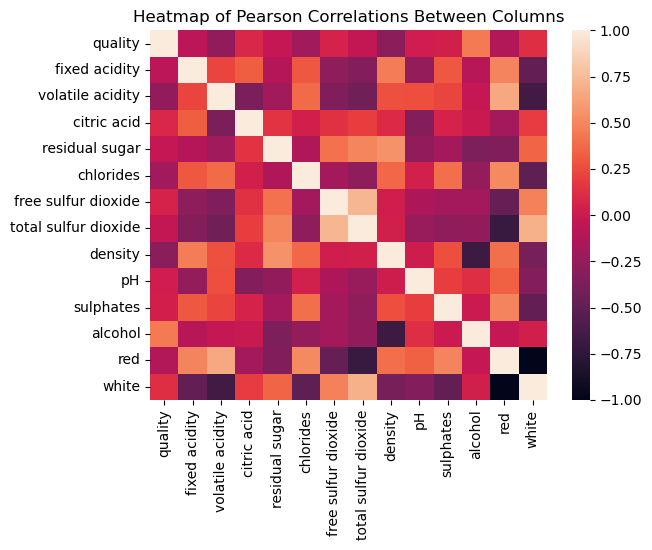

In [12]:
sns.heatmap(heatmap_df)
plt.title("Heatmap of Pearson Correlations Between Columns")
plt.show()

The heatmap helps us see how features correspond to each other. The middle of the map shows us that free sulfur dioxide and total sulfur dioxide are very correlated, which could mean that we could drop one of these features and not see a large impact on our algorithms. We also see that in the red and white columns, many of the features are highly correlated (either negatively or positively) to the type of wine. As we will see in our box plots in Question 1.3 later, the types have very similar quality distributions which might mean that we can remove the type features as the information is encoded into the chemical properties measured. One thing to note is that the most correlated feature to the quality variable is the alcohol content of the wine. 

# Question 1.2

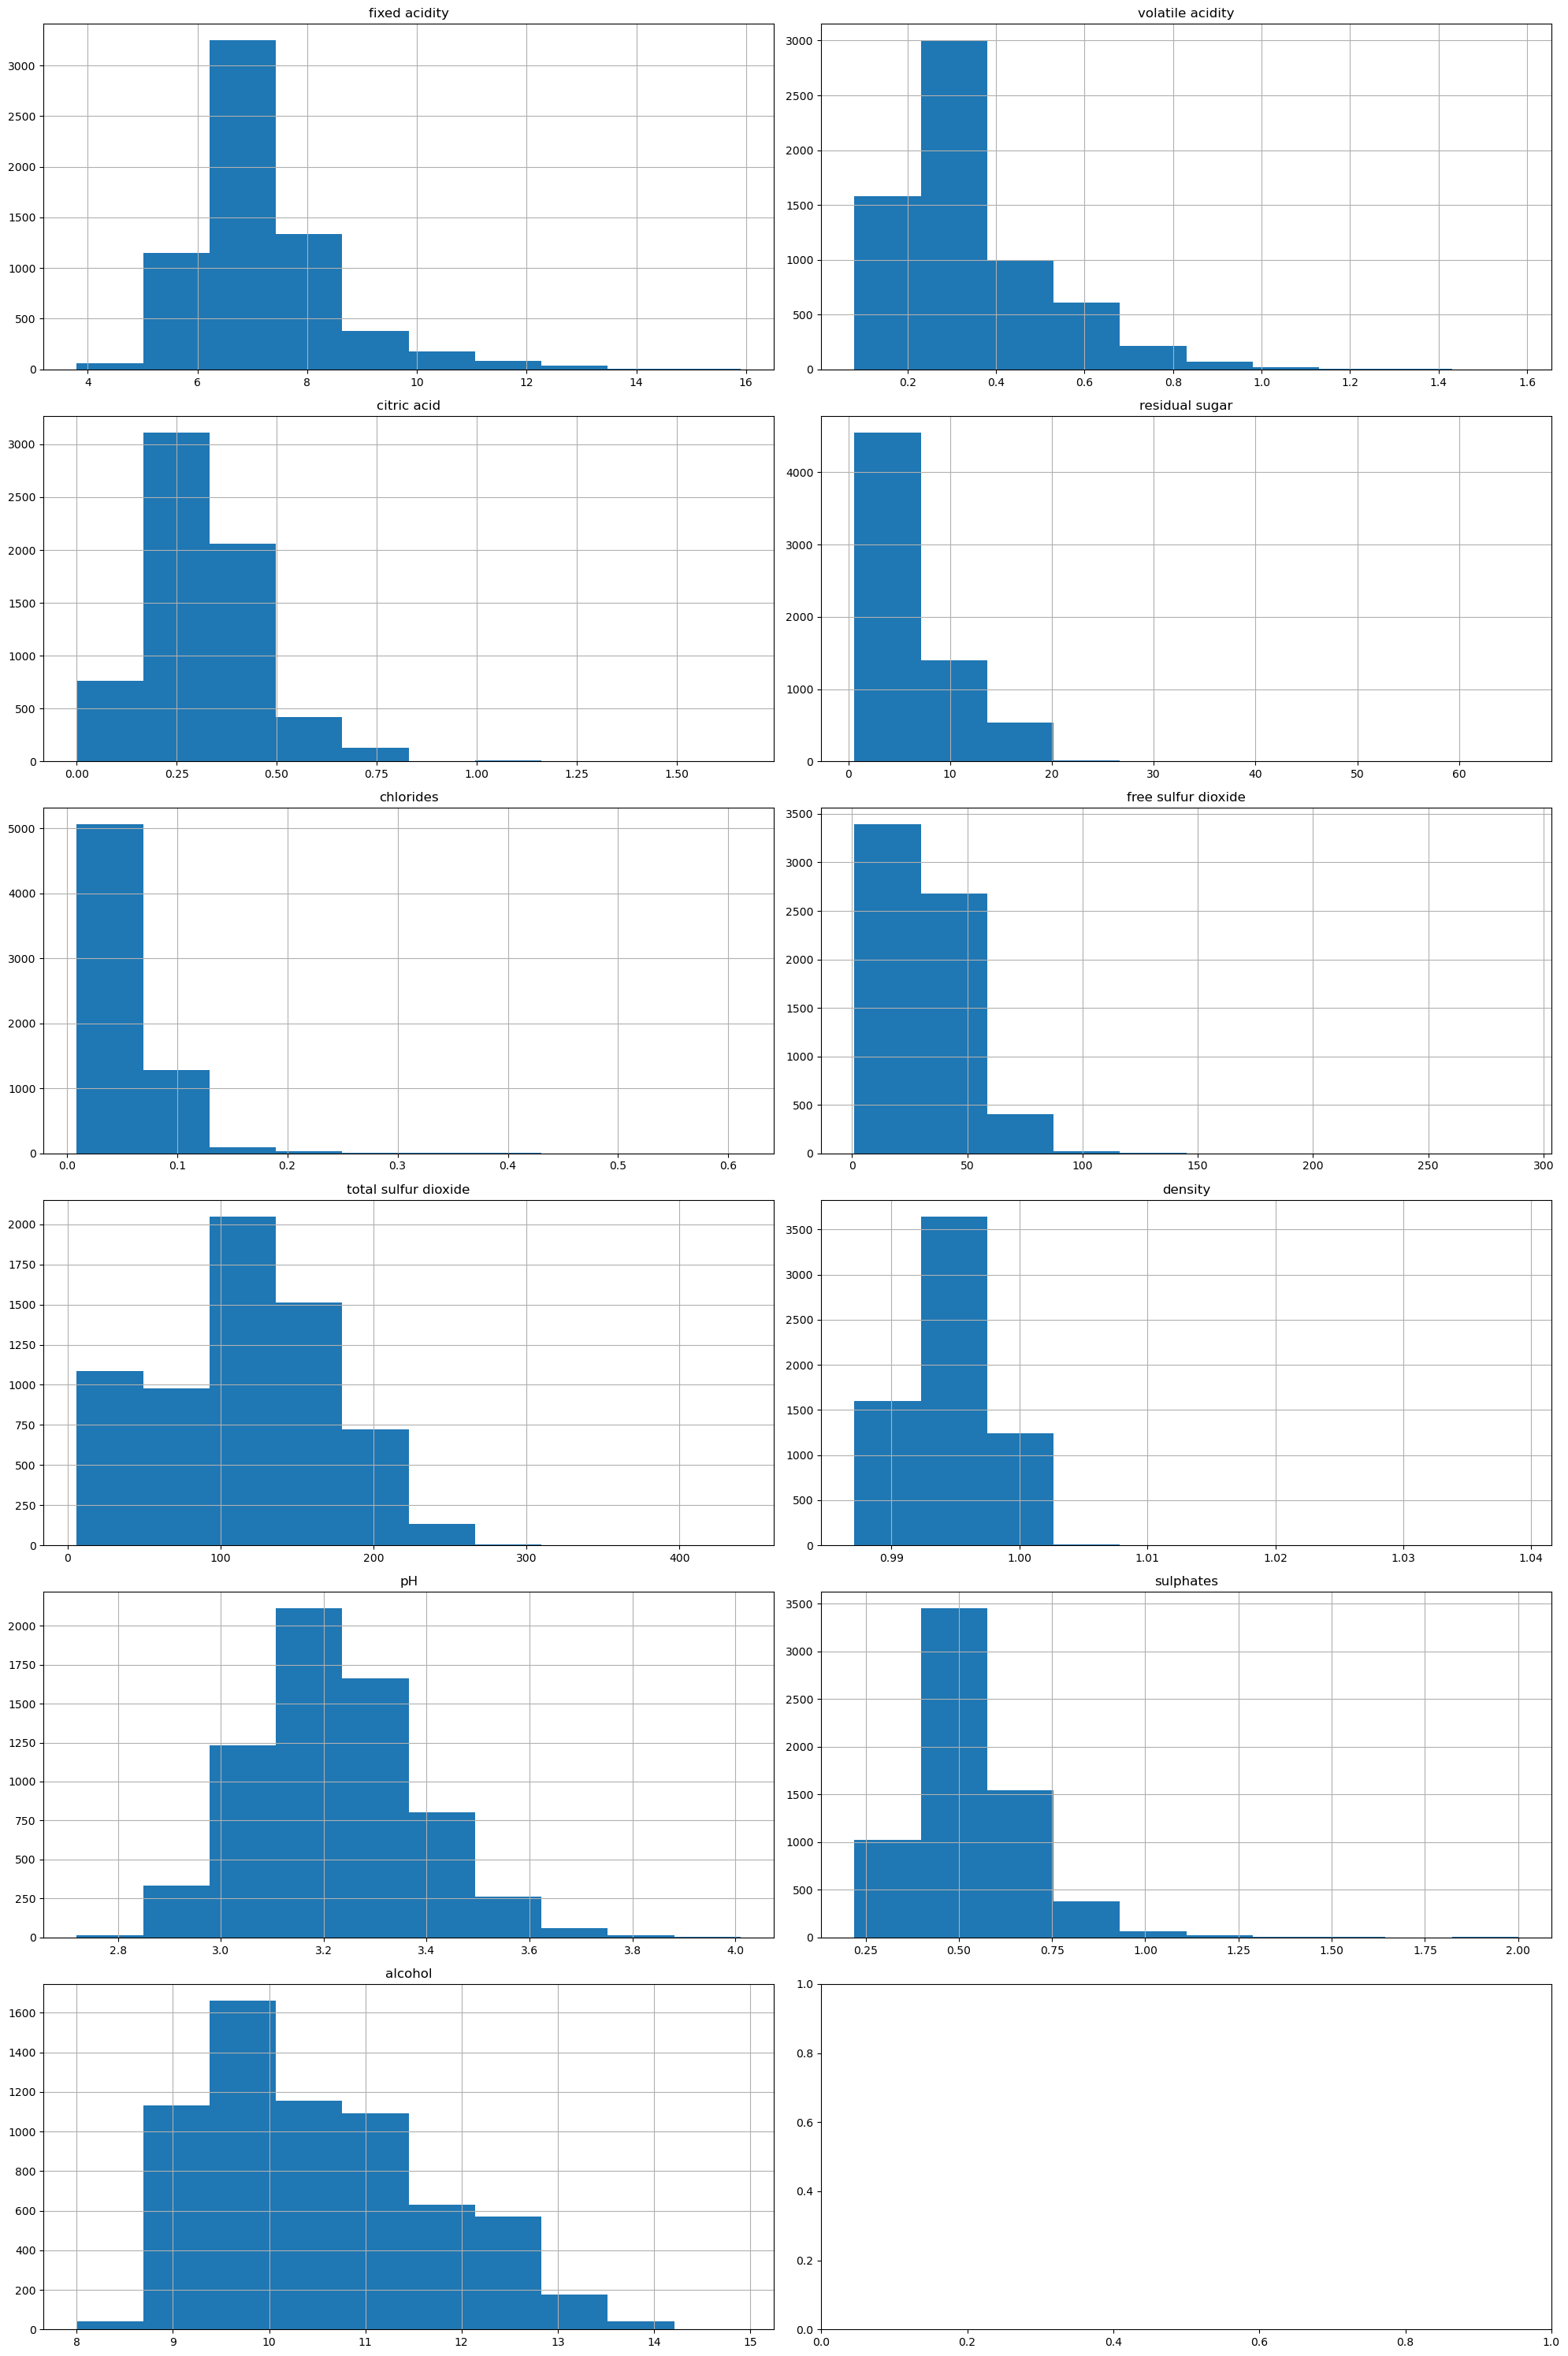

In [13]:
fig, ax = plt.subplots(len(num_cols)//2 + 1, 2)
for i in range(len(num_cols)):
    axis = ax[i//2][i%2]
    col = num_cols[i]
    wine_data.data.hist(col, ax=axis)
fig.set_figwidth(20)
fig.set_figheight(30)
fig.tight_layout()
fig.show()

The y-axis on all of these histograms is the number of occurrences of that specific bin. The x-axis is labeled above the graph. A few of these graphs are skewed to the right such as acidity but none of them are so skewed to required preprocessing. If this was required then a transformation can be applied to each feature in order to normalize it. One of the most popular techniques to do this with is log-scaling. 

# Question 1.3

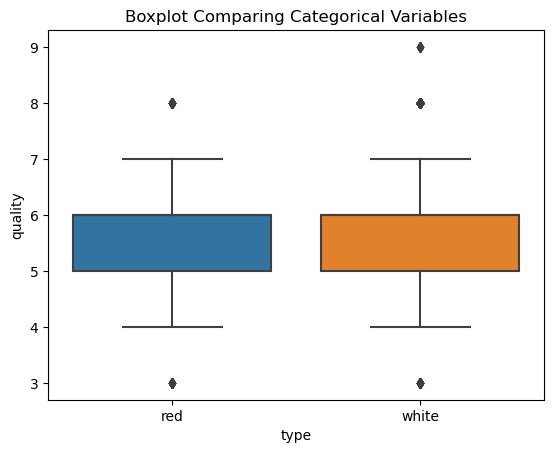

In [14]:
%matplotlib inline
fig, ax = plt.subplots(1, 1)
sns.boxplot(x = "type", y = "quality", data = wine_data.og_data, ax=ax)
ax.set_title("Boxplot Comparing Categorical Variables")
fig.show()

The only categorical variable in this dataset is the type (or color) of wine. The boxplot above is implying that the statistics for the whole dataset are about the same regardless of the type of wine. There are a few outliers in this dataset, depending on the amount of wines at these outlier points it may be worth removing them from our dataset so that our algorithms can not worry about fitting to them. 

# Question 1.4

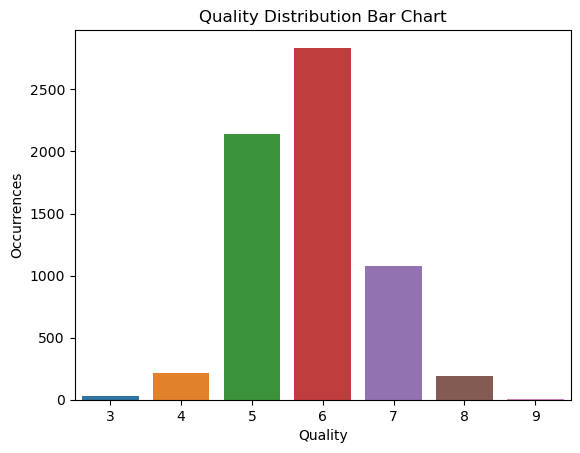

In [15]:
unique, counts = np.unique(wine_data.data['quality'], return_counts=True)
sns.barplot(x=unique, y=counts)
plt.title("Quality Distribution Bar Chart")
plt.xlabel("Quality")
plt.ylabel("Occurrences")
plt.show()

# Question 2.1 & 2.2

Note that in our code we stratify based on the color of the wine. Even though in our analysis we see not much dependence on the color of wine to the quality, the dataset is highly unbalanced and we would like to ensure that our testing set accurately represents the whole dataset. Some of the other parameters are highly reliant on the type of wine as can be seen in our heatmap so we want to ensure our algorithm is exposed to the full range of variables that are in the dataset and stratifying helps us achieve that. Later in the project we do not necessarily stratify our cross validation splits because in feature selection often the color characteristics are culled out. This is no matter, with 10 folds, it is highly unlikely that each fold will be so unbalanced and we take the best option.

Please see WinePreprocessing for the code on standardizing and feature selection. On a mathematical level, feature selection is removing information from the dataset so the accuracy of the model should suffer with ideal models. In practice however, certain features only serve to confuse models rather than help them, or provide no useful information if they are a linear combination of other features. We should expect to see a small decrease in the test RMSE using the reduced feature set across most model types. This is usually done for the benefit of reducing computational time. Some model types stand to benefit more than others. Smaller models that have trouble dealing with high dimensional data (such as clustering or simple linear models) feature selection helps them perform better. For more complicated models, feature selection can help reduce the curse of dimensionality which can cause serious overfitting in complex models. Extremely complicated models like deep learning neural networks can actually learn the feature selection process themselves in the early layers and it is often best to just feed all of the data into them. As such feature selection and its benefits are highly dependent on the end model you plan to use and what concerns you are trying to address.

In [16]:
sorted(processed_data.mi_scores())

[(0.003906622205269272, 'pH'),
 (0.010565924106434421, 'red'),
 (0.010565924106434421, 'white'),
 (0.02265923167267747, 'fixed acidity'),
 (0.032600532220745215, 'sulphates'),
 (0.0412193195855286, 'total sulfur dioxide'),
 (0.04238056468229079, 'citric acid'),
 (0.05148672047309244, 'chlorides'),
 (0.05187968018515665, 'free sulfur dioxide'),
 (0.06489547261569673, 'volatile acidity'),
 (0.07023899061893868, 'residual sugar'),
 (0.15135424583677892, 'density'),
 (0.15872843216878163, 'alcohol')]

This aligns with what we see in our heatmap of Pearson coefficients, alcohol having the highest MI score and the color the wine being one of the lowest. The two lowest features is pH and second place is tied between red and white (which makes sense because they have the same information). All three of these features are removed in our process leaving us with 10 total features in the reduced set. 

In [17]:
processed_data.data['metadata']['features']['reduced']

array(['fixed acidity', 'volatile acidity', 'citric acid',
       'residual sugar', 'chlorides', 'free sulfur dioxide',
       'total sulfur dioxide', 'density', 'sulphates', 'alcohol'],
      dtype=object)

# Question 4.1

From the sklearn documentation: "LinearRegression fits a linear model with coefficients w = (w1, …, wp) to minimize the residual sum of squares between the observed targets in the dataset, and the targets predicted by the linear approximation." The objective function here is the sum of the squares of the residuals.

In [19]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
lin_reg = TrainingHelper(LinearRegression(), processed_data, 'scaled')
lin_reg.cv()

{'fit_time': array([0.00148106, 0.00140595, 0.00157928, 0.00141406, 0.00154614,
        0.00161028, 0.00169373, 0.00239182, 0.00173759, 0.00146627]),
 'score_time': array([0.00049782, 0.00043797, 0.00050759, 0.00042629, 0.00079083,
        0.0005064 , 0.00058985, 0.00047278, 0.00044799, 0.00040936]),
 'estimator': [LinearRegression(),
  LinearRegression(),
  LinearRegression(),
  LinearRegression(),
  LinearRegression(),
  LinearRegression(),
  LinearRegression(),
  LinearRegression(),
  LinearRegression(),
  LinearRegression()],
 'test_score': array([-0.76196591, -0.68505105, -0.75116678, -0.75517336, -0.73775406,
        -0.72432703, -0.75671392, -0.76073417, -0.71623486, -0.72587427]),
 'train_score': array([-0.73248265, -0.74097054, -0.73365121, -0.73334961, -0.73518379,
        -0.7367453 , -0.73301396, -0.73270297, -0.73749461, -0.73647238])}

In [ ]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import cross_validate

regular = LinearRegression()
cross_validate(regular, X_train_transformed, y_train, cv=10, scoring=RMSE_SCORING)

{'fit_time': array([0.00573444, 0.00335312, 0.00278115, 0.00242639, 0.00282884,
        0.00256586, 0.00237966, 0.0021441 , 0.00213242, 0.00372696]),
 'score_time': array([0.00280523, 0.00110888, 0.00123072, 0.00101423, 0.00208354,
        0.00198245, 0.00104761, 0.00090337, 0.00208044, 0.00095606]),
 'test_score': array([-0.73538106, -0.78949299, -0.72745237, -0.72820935, -0.76345091,
        -0.69142787, -0.74692375, -0.74683341, -0.74188109, -0.67688904])}

In [ ]:
lasso = Lasso()
for reg_strength in [1e-2, 0.1, 1, 10]:
    lasso.set_params(alpha=reg_strength)
    print(f"{reg_strength=}")
    print(cross_validate(lasso, X_train_transformed, y_train, cv=10, scoring="neg_root_mean_squared_error"))

reg_strength=0.01
{'fit_time': array([0.00503707, 0.00417304, 0.00332665, 0.00285506, 0.00364566,
       0.00371623, 0.00335407, 0.00332332, 0.00318623, 0.00322866]), 'score_time': array([0.0012238 , 0.00109601, 0.00101399, 0.00094938, 0.00124836,
       0.0012517 , 0.00104594, 0.00112987, 0.00123477, 0.00106525]), 'test_score': array([-0.7360599 , -0.79224614, -0.72622977, -0.73313064, -0.76849487,
       -0.69657249, -0.75060802, -0.75621232, -0.74653502, -0.67818368])}
reg_strength=0.1
{'fit_time': array([0.00204754, 0.00237465, 0.00182223, 0.00231194, 0.00189137,
       0.00177741, 0.00179577, 0.00191522, 0.00197577, 0.00239611]), 'score_time': array([0.00168705, 0.00103664, 0.00085092, 0.0009234 , 0.00088644,
       0.00084949, 0.00090528, 0.00086331, 0.00116563, 0.00117946]), 'test_score': array([-0.76359596, -0.8203581 , -0.75915196, -0.75997659, -0.79468443,
       -0.73112349, -0.76737184, -0.78033139, -0.76823767, -0.7039179 ])}
reg_strength=1
{'fit_time': array([0.00212383, 

In [ ]:
ridge = Ridge()
for reg_strength in [1e-2, 0.1, 1, 10]:
    ridge.set_params(alpha=reg_strength)
    print(f"{reg_strength=}")
    print(cross_validate(ridge, X_train_transformed, y_train, cv=10, scoring="neg_root_mean_squared_error"))

reg_strength=0.01
{'fit_time': array([0.00235009, 0.00202084, 0.00199819, 0.00192976, 0.00182557,
       0.00189495, 0.0018127 , 0.00191379, 0.00206614, 0.00199604]), 'score_time': array([0.0012784 , 0.0009141 , 0.000911  , 0.00098515, 0.0010941 ,
       0.00086451, 0.00084662, 0.00106239, 0.00127792, 0.00100684]), 'test_score': array([-0.73538081, -0.78949287, -0.72745109, -0.72820938, -0.76345105,
       -0.69142792, -0.7469238 , -0.7468338 , -0.74188128, -0.67688893])}
reg_strength=0.1
{'fit_time': array([0.00223684, 0.00203109, 0.00233555, 0.00212359, 0.00222301,
       0.00233817, 0.00203538, 0.00198174, 0.00178576, 0.00174522]), 'score_time': array([0.00110245, 0.00101137, 0.00112987, 0.00109744, 0.0012908 ,
       0.00109553, 0.00113416, 0.00108218, 0.00088191, 0.00110292]), 'test_score': array([-0.73537854, -0.78949177, -0.72743965, -0.72820967, -0.76345234,
       -0.6914284 , -0.74692421, -0.74683738, -0.74188301, -0.67688796])}
reg_strength=1
{'fit_time': array([0.00202203, 

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
degrees = [2,3,4,5,6]
reg_strengths = [1e-2, 0.1, 1, 10]
poly_results = []
for degree in degrees:
    degree_results = []
    poly_features = PolynomialFeatures(degree=degree)
    X_train_poly = poly_features.fit_transform(X_train_transformed)
    for reg_strength in reg_strengths:
        poly_ridge = Ridge(alpha=reg_strength)
        degree_results.append(max(cross_validate(poly_ridge, X_train_poly, y_train, cv=10, scoring="neg_root_mean_squared_error")['test_score']))
    poly_results.append(degree_results)

poly_df = pd.DataFrame(poly_results, index=degrees, columns=reg_strengths)
poly_df

/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:241: LinAlgWarning: Ill-conditioned matrix (rcond=3.55307e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:241: LinAlgWarning: Ill-conditioned matrix (rcond=2.1014e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:241: LinAlgWarning: Ill-conditioned matrix (rcond=2.10442e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:241: LinAlgWarning: Ill-conditioned matrix (rcond=4.93293e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="po

,0.01,0.10,1.00,10.00
2,-0.651664,-0.651667,-0.651698,-0.651815
3,-0.745914,-0.746445,-0.745296,-0.724311
4,-1.793769,-1.363407,-1.110647,-0.940401
5,-40.669759,-26.943130,-8.363894,-5.479763
6,-72.055366,-26.910922,-34.279058,-16.629763


In [ ]:
X_train_transformed

array([[-0.08751629,  0.73733262, -0.61536113, ..., -0.91477744,
        -0.57135108,  0.57135108],
       [ 1.13872926,  1.77191691, -0.2718561 , ..., -0.24216331,
         1.75023733, -1.75023733],
       [-0.77727941, -0.84497276, -0.40925811, ...,  0.43045083,
        -0.57135108,  0.57135108],
       ...,
       [-0.01087594,  0.31132733,  0.82735998, ...,  0.85083467,
         1.75023733, -1.75023733],
       [-0.47071802, -1.08840436,  1.72047304, ..., -0.99885421,
        -0.57135108,  0.57135108],
       [-0.08751629, -0.29725167,  0.14034993, ...,  0.17822053,
        -0.57135108,  0.57135108]])

In [21]:
from torch import nn
import torch

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

In [22]:
learning_rate = 1e-3
batch_size = 64
epochs = 10

class BasicNN (nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.model = nn.Sequential(
            nn.LazyLinear(32), nn.ReLU(),
            nn.LazyLinear(128), nn.ReLU(),
            nn.LazyLinear(32), nn.ReLU(),
            nn.LazyLinear(1)
        )

    def forward(self, x):
        res = self.model(x)
        return res
    
def train_loop(dataloader, model, loss_fn, optimizer):
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

def test_loop(dataloader, model, loss_fn):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    num_batches = len(dataloader)
    test_loss = 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()

    test_loss /= num_batches
    return test_loss
    

In [24]:
from sklearn.model_selection import KFold
from torch.utils.data import TensorDataset, DataLoader
import torch
from tqdm import tqdm

kf = KFold(10)
for kf_train, kf_val in kf.split(X_train_transformed, y_train.to_numpy()):
    X_train_tensor = torch.Tensor(X_train_transformed[kf_train]).to(device)
    y_train_tensor = torch.Tensor(y_train.to_numpy()[kf_train]).to(device)
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, drop_last=True)

    X_val_tensor = torch.Tensor(X_train_transformed[kf_val]).to(device)
    y_val_tensor = torch.Tensor(y_train.to_numpy()[kf_val]).to(device)
    val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
    val_dataloader = DataLoader(val_dataset)

    model = BasicNN().to(device)
    mse = nn.MSELoss()
    loss_fn = lambda y_hat, y: torch.sqrt(mse(y_hat, y))
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

    for t in tqdm(range(epochs)):
        train_loop(train_dataloader, model, loss_fn, optimizer)
        epoch_train_loss = test_loop(train_dataloader, model, loss_fn)
        epoch_val_loss = test_loop(val_dataloader, model, loss_fn)
        if t == epochs - 1:
            print(f"Final Training loss: {epoch_train_loss}")
            print(f"Final Validation loss: {epoch_val_loss}")

100%|██████████| 10/10 [00:03<00:00,  2.99it/s]


Final Training loss: 1.3108517829685995
Final Validation loss: 1.0190046823941745


100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


Final Training loss: 2.5577517829529226
Final Validation loss: 2.3586826576636386


100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


Final Training loss: 1.4311935852651727
Final Validation loss: 1.1848936401880705


100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


Final Training loss: 3.98973342163922
Final Validation loss: 3.9562090740754052


100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


Final Training loss: 2.0130878997175663
Final Validation loss: 1.7729549852701334


100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


Final Training loss: 3.275870329713168
Final Validation loss: 3.077106464826144


100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


Final Training loss: 1.6764734493543023
Final Validation loss: 1.3491469296125265


100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


Final Training loss: 3.816539330025242
Final Validation loss: 3.7177462619164086


100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


Final Training loss: 2.9619426008773178
Final Validation loss: 2.8405238479548105


100%|██████████| 10/10 [00:03<00:00,  3.25it/s]

Final Training loss: 3.2942681345221114
Final Validation loss: 3.183239862868322


In [27]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

grid =  {
    "n_estimators": [100],
    "max_depth": [5],
    "max_features": [1]
}

random_forest = RandomForestRegressor()

random_forest_grid_search = GridSearchCV(random_forest, grid, cv=10, scoring="neg_root_mean_squared_error")
random_forest_grid_search.fit(X_train_transformed, y_train)

GridSearchCV(cv=10, estimator=RandomForestRegressor(),
             param_grid={'max_depth': [5], 'max_features': [1],
                         'n_estimators': [100]},
             scoring='neg_root_mean_squared_error')

In [28]:
random_forest_grid_search.cv_results_

{'mean_fit_time': array([0.14177434]),
 'std_fit_time': array([0.00583588]),
 'mean_score_time': array([0.00558074]),
 'std_score_time': array([8.15330923e-05]),
 'param_max_depth': masked_array(data=[5],
              mask=[False],
        fill_value='?',
             dtype=object),
 'param_max_features': masked_array(data=[1],
              mask=[False],
        fill_value='?',
             dtype=object),
 'param_n_estimators': masked_array(data=[100],
              mask=[False],
        fill_value='?',
             dtype=object),
 'params': [{'max_depth': 5, 'max_features': 1, 'n_estimators': 100}],
 'split0_test_score': array([-0.73526804]),
 'split1_test_score': array([-0.74967849]),
 'split2_test_score': array([-0.75960609]),
 'split3_test_score': array([-0.79502052]),
 'split4_test_score': array([-0.73393977]),
 'split5_test_score': array([-0.74861039]),
 'split6_test_score': array([-0.81821186]),
 'split7_test_score': array([-0.76239949]),
 'split8_test_score': array([-0.755903

In [24]:
import lightgbm as lgbm

lgbm_reg = lgbm.LGBMRegressor()

lgbm_grid = {
    "num_leaves": [70]
}

In [25]:
from skopt import BayesSearchCV

opt = BayesSearchCV(lgbm_reg, lgbm_grid, n_iter=32, cv=10, scoring="neg_root_mean_squared_error")
opt.fit(X_train_transformed, y_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007472 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1536
[LightGBM] [Info] Number of data points in the train set: 4677, number of used features: 13
[LightGBM] [Info] Start training from score 5.817404
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000127 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1540
[LightGBM] [Info] Number of data points in the train set: 4677, number of used features: 13
[LightGBM] [Info] Start training from score 5.822750
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000120 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1534
[LightGBM] [Info] Number of data points in the train set: 

BayesSearchCV(cv=10, estimator=LGBMRegressor(), n_iter=32,
              scoring='neg_root_mean_squared_error',
              search_spaces={'num_leaves': [70]})